# Notebook to visualise output from large training routines carried out on fields

In [5]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
from plot import *
from utils import *

matplotlib.rcParams["savefig.dpi"] = 200
matplotlib.rcParams["legend.frameon"] = False
matplotlib.rcParams.update({'font.size': 18})

In [6]:
# useful to define the model structures we will be using here
 ### Define the different hLN architectures we will be using:
# 1L
Jc_1l = np.array([0])
# 1N
Jc_1n = np.array([0])
# 2N
Jc_2n = np.array([0, 1, 1])
# 3N
Jc_3n = np.array([0, 1, 1, 2, 2, 3, 3])
# 4N
Jc_4n = np.array([0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7])

# list of lists for to define hierarchical clustering
clusts = [[[[[0, 1], [2]], [[3, 4], [5, 6]]], [[[7, 8], [9]], [[10, 11], [12]]]]]

Wce_1l, Wci_1l = create_weights(Jc_1l, n_levels=1, clusts=clusts)
Wce_2n, Wci_2n = create_weights(Jc_2n, n_levels=2, clusts=clusts)
Wce_3n, Wci_3n = create_weights(Jc_3n, n_levels=3, clusts=clusts)
Wce_4n, Wci_4n = create_weights(Jc_4n, n_levels=4, clusts=clusts)

In [5]:
loaded = np.load('/tmp/training_data.npz', allow_pickle=True)

In [6]:
train_accs, test_accs, trained_plist, target_plist = loaded['a'], loaded['b'], loaded['c'], loaded['d']

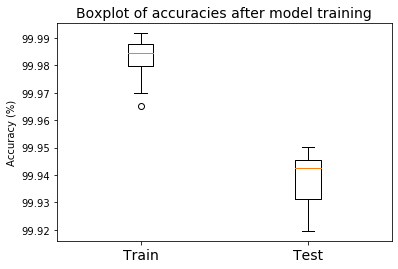

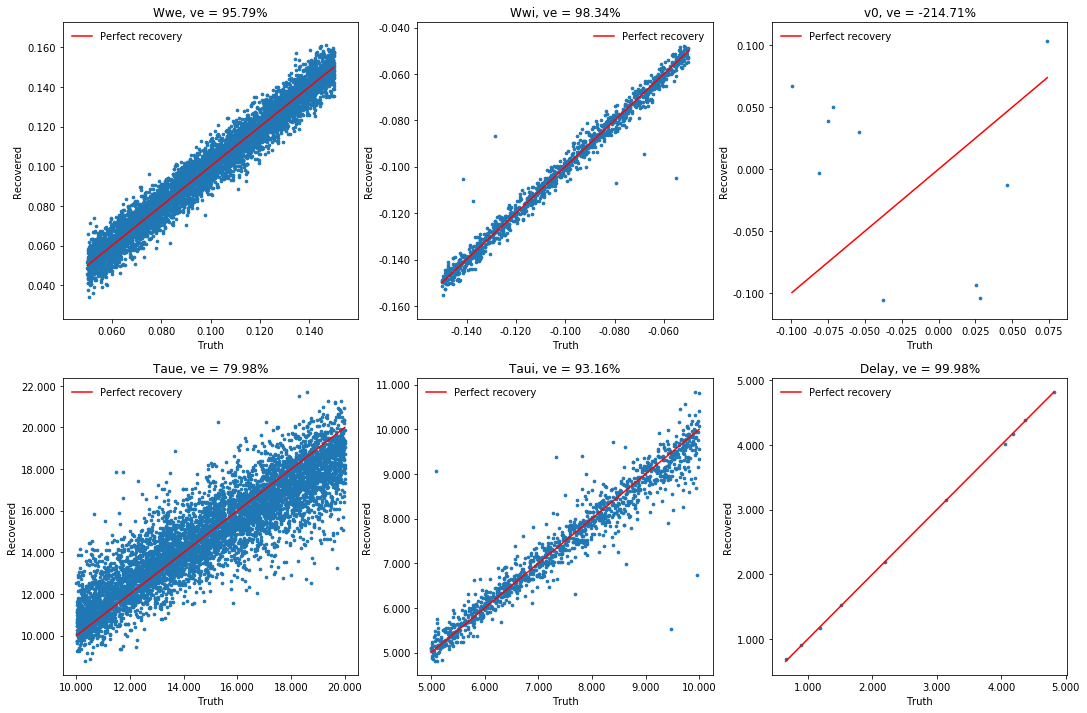

In [7]:
box_accuracies(accuracies=[train_accs, test_accs], labels=['Train', 'Test'])
plot_params_1li(trained_plist, target_plist)

In [186]:
loaded_models = np.load('/Users/EdPhillips/Documents/Cambridge4/Project/Data/trained_models_amsgrad_1l.npz', allow_pickle=True)

In [187]:
target_params_list, trained_params_list, inputs = loaded_models['a'], loaded_models['b'], loaded_models['c']

In [188]:
# split input data into training, validation and test sets
L = inputs.shape[1]
train_split = 0.7
n_train = int(L * train_split)
train_inputs = inputs[:, :n_train]
val_split = 0.1
n_val = int(L * val_split)
val_inputs = inputs[:, n_train:n_train + n_val]
n_test = L - n_train - n_val
test_inputs = inputs[:, -n_test:]

In [190]:
# reload parameters, create models with them and extract accuracy metrics

train_accs_list_amsgrad_1l=[]
test_accs_list_amsgrad_1l=[]

for j in range(len(target_params_list)):
    params_1l = trained_params_list[j][0]
    params_1n = trained_params_list[j][1]
    params_2n = trained_params_list[j][2]
    params_3n = trained_params_list[j][3]
    params_4n = trained_params_list[j][4]

    hln_1l = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
    for i in range(len(hln_1l.params)):
        hln_1l.params[i].assign(params_1l[i])

    hln_1n = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([True]))
    for i in range(len(hln_1n.params)):
        hln_1n.params[i].assign(params_1n[i])

    hln_2n = hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, True, True]))
    for i in range(len(hln_2n.params)):
        hln_2n.params[i].assign(params_2n[i])

    hln_3n = hLN_Model(Jc=Jc_3n, Wce=Wce_3n, Wci=Wci_3n, sig_on=tf.constant([True, True, True,
                                                                             True, True, True, True]))
    for i in range(len(hln_3n.params)):
        hln_3n.params[i].assign(params_3n[i])

    hln_4n = hLN_Model(Jc=Jc_4n, Wce=Wce_4n, Wci=Wci_4n, sig_on=tf.constant([True, True, True, True, True, True, True,
                                                                             True, True, True, True, True, True, True,
                                                                             True]))
    for i in range(len(hln_4n.params)):
        hln_4n.params[i].assign(params_4n[i])

    target_model=hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))

    for i in range(len(target_model.params)):
        target_model.params[i].assign(target_params_list[j][i])
        
        
    # generate target traces 
    train_target = target_model(train_inputs)
    val_target = target_model(val_inputs)
    test_target = target_model(test_inputs)    
        
        
    # evaluate models on test data:
    train_accs, test_accs = [], []
    models=[hln_1l, hln_1n, hln_2n, hln_3n, hln_4n]
    for model in models:
        train_out, test_out = model(train_inputs), model(test_inputs)
        train_acc = 100 * (1-loss(train_out, train_target)/np.var(train_target))
        test_acc = 100 * (1-loss(test_out, test_target)/np.var(test_target))
        train_accs.append([train_acc.numpy()])
        test_accs.append(test_acc.numpy())

    train_accs_list_amsgrad_1l.append(train_accs)
    test_accs_list_amsgrad_1l.append(test_accs)

In [92]:
train_accs_arr = np.squeeze(np.clip(np.array(train_accs_list), a_min=0, a_max=None))
test_accs_arr = np.squeeze(np.clip(np.array(test_accs_list), a_min=0, a_max=None))

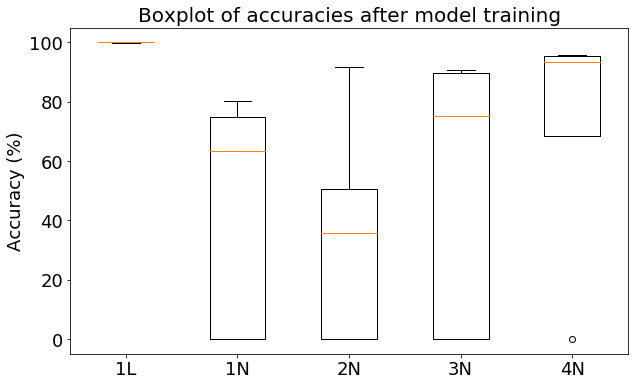

In [130]:
train_accs = np.array(train_accs, ndmin=2)
test_accs = np.array(test_accs, ndmin=2)
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training', fontsize=20)
ax.boxplot(train_accs_arr)
ax.set_xticklabels(['1L', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()
# box_accuracies(accuracies=np.squeeze(train_accs_arr), labels=['1L', '1N', '2N', '3N', '4N'])


<tf.Tensor: shape=(1,), dtype=bool, numpy=array([False])>

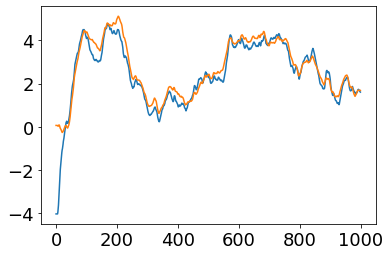

In [104]:
plt.plot(hln_4n(val_inputs).numpy().T[:1000], label='1L attempt')
plt.plot(val_target.numpy().T[:1000], label='Target')
target_model.sig_on

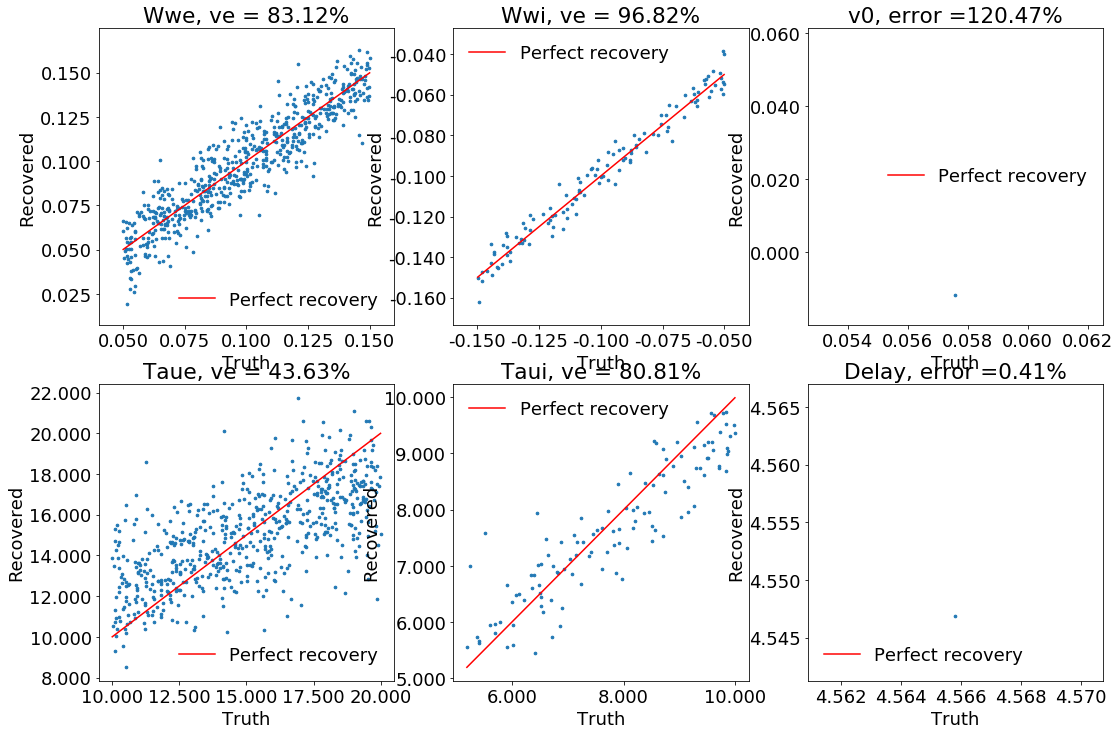

In [117]:
plot_params_1li(trained_params=[params_1l], target_params=[target_params_list[4]])

## Now take trained 1L model and initialise and train each complex model in turn: where are we going wrong?

In [128]:
trained_1l = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
for i in range(len(hln_1n.params)):
        hln_1n.params[i].assign(params_1n[i])
attempt_1l = trained_1l(train_inputs)
acc_1l= 100*(1-(loss(train_target, attempt_1l)/np.var(train_target)))
print(acc_1l)

tf.Tensor(96.95021, shape=(), dtype=float32)


In [125]:
# now initialise 1n model and train for certain number of epochs
untrained_1n = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([True]))
init_nonlin(X=train_inputs, model=untrained_1n, lin_model=trained_1l, nSD=50)
attempt_1n = untrained_1n(train_inputs)
acc_1n = 100*(1-(loss(train_target, attempt_1n)/np.var(train_target)))
print(acc_1n)

tf.Tensor(95.15826, shape=(), dtype=float32)


In [136]:
train_accs_arr_1l3 = np.squeeze(np.clip(np.array(train_accs_list_1l3), a_min=0, a_max=None))
test_accs_arr_1l3 = np.squeeze(np.clip(np.array(test_accs_list_1l3), a_min=0, a_max=None))

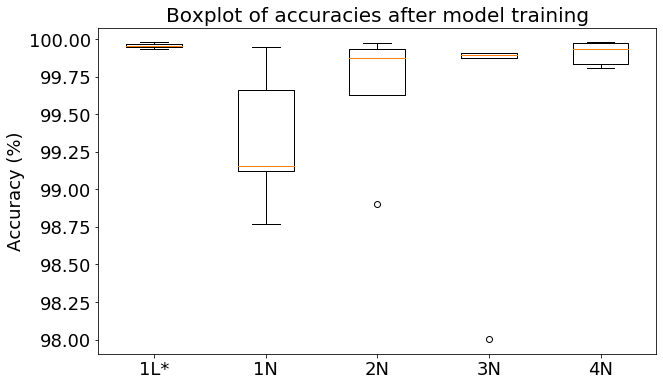

In [184]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training', fontsize=20)
ax.boxplot(train_accs_arr_1l3)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()
# box_accuracies(accuracies=np.squeeze(train_accs_arr), labels=['1L', '1N', '2N', '3N', '4N'])

In [143]:
train_accs_arr_3n = np.squeeze(np.clip(np.array(train_accs_list_3n), a_min=0, a_max=None))
test_accs_arr_3n = np.squeeze(np.clip(np.array(test_accs_list_3n), a_min=0, a_max=None))

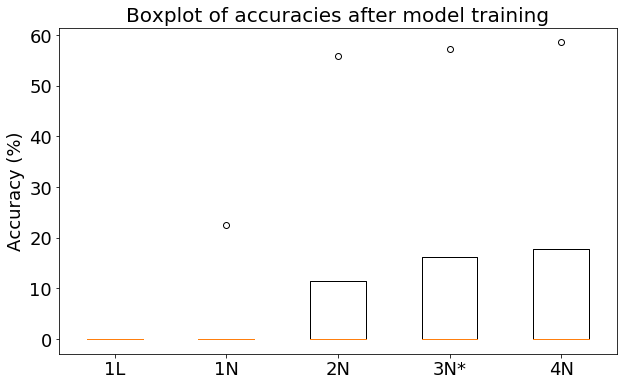

In [185]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training', fontsize=20)
ax.boxplot(train_accs_arr_3n)
ax.set_xticklabels(['1L', '1N', '2N', '3N*', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()
# box_accuracies(accuracies=np.squeeze(train_accs_arr), labels=['1L', '1N', '2N', '3N', '4N'])

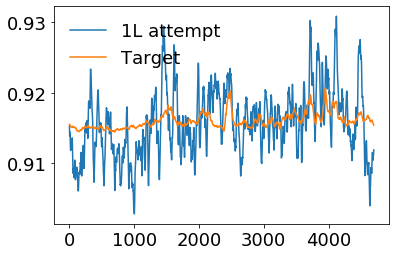

In [163]:
plt.plot(hln_4n(val_inputs).numpy().T[100:], label='1L attempt')
plt.plot(val_target.numpy().T[100:], label='Target')
plt.legend()
# target_model.sig_on

In [168]:
train_accs_arr_3n2 = np.squeeze(np.clip(np.array(train_accs_list_3n2), a_min=0, a_max=None))
test_accs_arr_3n2 = np.squeeze(np.clip(np.array(test_accs_list_3n2), a_min=0, a_max=None))

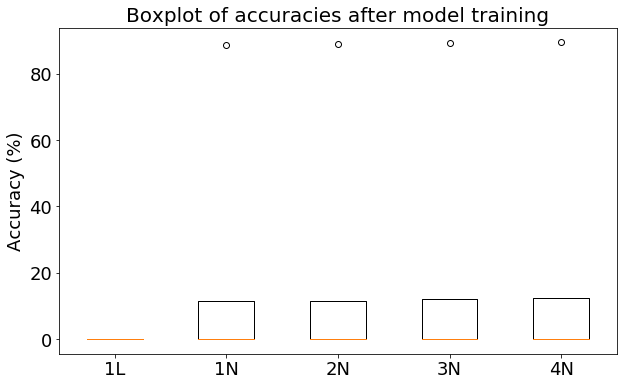

In [171]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training', fontsize=20)
ax.boxplot(train_accs_arr_3n2)
ax.set_xticklabels(['1L', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()

In [173]:
train_accs_arr_3n2

array([[ 0.      , 11.427223, 11.554128, 12.132227, 12.34796 ],
       [ 0.      , 88.679436, 88.99115 , 89.41328 , 89.494385],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ]],
      dtype=float32)

In [174]:
test_accs_arr_3n2

array([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     , 77.49548, 78.25777, 79.04724, 78.83434],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ]], dtype=float32)

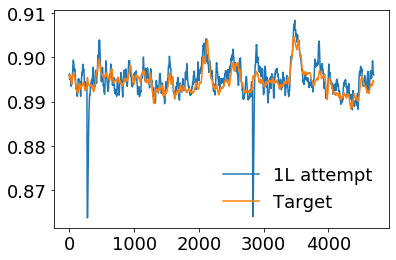

In [182]:
plt.plot(hln_4n(val_inputs).numpy().T[100:], label='1L attempt')
plt.plot(val_target.numpy().T[100:], label='Target')
plt.legend()

## Clear problem with Adam optimizer for >1L models and 1L target - training accuracy should not go down when we step up a model. Next run some experiments with Amsgrad variant to try and solve

In [191]:
train_accs_arr_amsgrad_1l = np.squeeze(np.clip(np.array(train_accs_list_amsgrad_1l), a_min=0, a_max=None))
test_accs_arr_amsgrad_1l = np.squeeze(np.clip(np.array(test_accs_list_amsgrad_1l), a_min=0, a_max=None))

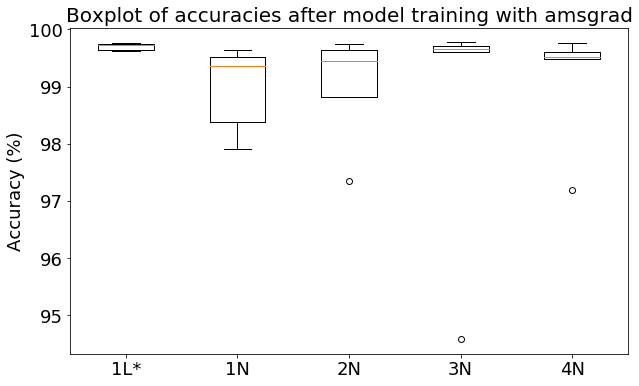

In [194]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.set_title('Boxplot of accuracies after model training with amsgrad', fontsize=20)
ax.boxplot(test_accs_arr_amsgrad_1l)
ax.set_xticklabels(['1L*', '1N', '2N', '3N', '4N'], fontsize=18)
ax.set_ylabel("Accuracy (%)", fontsize=18)
# ax.set_ylim(99.9,100.01)
# ax.set_ylim(100)

plt.show()